In [1]:
import model_lib
import os
import params
import data_preparation
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import trange
tfd = tfp.distributions
keras = tf.keras
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

NUM_ClASSES = len(params.brand_models)

In [2]:
def parse_image(filename, post_processing=None):
    label =  tf.strings.split(filename, os.sep)[-1]
    images = data_preparation._patchify(filename).reshape((-1, 256, 256))
    images = tf.image.convert_image_dtype(images, tf.float32)
    images = images[..., tf.newaxis]
    if post_processing == True:
        images = tf.image.random_flip_left_right(images)
#         images = tf.image.random_brightness(images, max_delta=32.0 / 255.0)
#         images = tf.clip_by_value(images, 0.0, 1.0)
        imgs = images
        images = None
#         images = tf.stack([tfa.image.gaussian_filter2d(imgs[i]) for i in range(25)])
        images = tf.stack([tf.image.adjust_jpeg_quality(images[i], 70) for i in range(25)])
    return images, label

In [3]:
def compute_probs(images, num_monte_carlo=30):
    probs = tf.stack([tf.keras.layers.Activation('softmax')(model(images)) for _ in range(num_monte_carlo)], axis=0)
    mean_probs = tf.reduce_mean(probs, axis=0)
    eps = tf.convert_to_tensor(np.finfo(float).eps, dtype=tf.float32)
    sum_log_prob = -tf.reduce_sum(tf.math.multiply(mean_probs, tf.math.log(mean_probs + eps)), axis=1)
    heldout_log_prob = tf.reduce_mean(sum_log_prob)
    print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))
    return probs, heldout_log_prob

In [4]:
def decompose_uncertainties(p_hat):
    """
    Given a number of draws, decompose the predictive variance into aleatoric and epistemic uncertainties.
    Explanation: https://github.com/ykwon0407/UQ_BNN/issues/3
      T: number of draws from the model
      K: number of classes

    For squashing the resulting matrices into a single scalar, there are multiple options:
      * Sum/Average over all elements can result in negative outcomes.
      * Sum/Average over diagonal elements only.
    :param p_hat: ndarray of shape [num_draws, num_classes]
    :return: aleatoric and epistemic uncertainties, each is an ndarray of shape [num_classes, num_classes]
        The diagonal entries of the epistemic uncertainties matrix represents the variances, i.e., np.var(p_hat, axis=0)).
    """

    num_draws = p_hat.shape[0]
    p_mean = np.mean(p_hat, axis=0)

    # Aleatoric uncertainty: \frac{1}{T} \sum\limits_{t=1}^T diag(\hat{p_t}) - \hat{p_t} \hat{p_t}^T
    # Explanation: Split into two sums.
    # 1. \frac{1}{T} \sum\limits_{t=1}^T diag(\hat{p_t})
    #    This is equal to the diagonal of p_mean.
    # 2. \frac{1}{T} \sum\limits_{t=1}^T - \hat{p_t} \hat{p_t}^T
    #    For each element of the sum this produces an array of shape [num_classes, num_classes]
    #    This can be vectorized with dot(p_hat^T, p_hat), which is [num_classes, num_draws] * [num_draws, num_classes] -> [num_classes, num_classes]
    #    Eventually, we need to divide by T
    aleatoric = np.diag(p_mean) - p_hat.T.dot(p_hat) / num_draws

    # Epistemic uncertainty: \frac{1}{T} \sum\limits_{t=1}^T (\hat{p_t} - \bar{p}) (\hat{p_t} - \bar{p})^T
    tmp = p_hat - p_mean
    epistemic = tmp.T.dot(tmp) / num_draws

    return aleatoric, epistemic

In [5]:
def plot_held_out(images, img_name, probs, heldout_log_prob, n):
    fig = plt.figure(figsize=(12, 3*n))
    color_list = ['b', 'C1', 'g']
    d2c = dict(zip(params.brand_models, color_list))
    for i in range(n):
        ax = fig.add_subplot(n, 3, 3*i + 1)
        ax.imshow(images[i, :, :, 0], interpolation='None', cmap='gray')
        ax.set_title(img_name)
        ax.axis('off')
        ax = fig.add_subplot(n, 3, 3*i + 2)
        for prob_sample in probs:
            sns.barplot(np.arange(NUM_ClASSES), prob_sample[i, :], alpha=0.1, ax=ax)
            ax.set_ylim([0, 1])
            ax.set_xticklabels(params.brand_models, fontdict={'fontsize': 8})
        ax.set_title('posterior samples')
        ax = fig.add_subplot(n, 3, 3*i + 3)
        aleatoric, epistemic = decompose_uncertainties(probs.numpy()[:,i,:])
        df = pd.DataFrame(probs.numpy()[:,i,:], columns=params.brand_models)
        ax = df.mean(axis=0).plot(kind='bar', color=map(d2c.get, df.columns), 
                                  yerr=df.std(axis=0), rot=0, capsize=5)
        ax.set_ylim([0, 1])
        ax.set_xticklabels(params.brand_models, fontdict={'fontsize': 8})
#         print(df.std(axis=0))
        ax.set_title('epistemic uncertainty\n {}'.format(np.diag(epistemic)))

    fig.suptitle('Held-out nats: {:.3f}'.format(heldout_log_prob), y=1.0)
    fig.tight_layout()

In [6]:
def plot_weight_posteriors(names, qm_vals, qs_vals):
    """Save a PNG plot with histograms of weight means and stddevs.
    Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title('weight means')
    ax.set_xlim([-1.5, 1.5])
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title('weight stddevs')
    ax.set_xlim([0, 1.])

    fig.tight_layout()

In [7]:
train_size = 0
for m in params.brand_models:
    train_size += len(os.listdir(os.path.join(params.patches_dir, 'train', m)))

In [8]:
# use for initialization?
# fully-factorized M-dimensional Gaussian
def _posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    """Posterior function for variational layer."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1e-5))
    variable_layer = tfp.layers.VariableLayer(2 * n, dtype=dtype,
                        initializer=tfp.layers.BlockwiseInitializer([
                        keras.initializers.TruncatedNormal(mean=0., stddev=.05, seed=None),
                        keras.initializers.Constant(np.log(np.expm1(1e-5)))], sizes=[n, n]))

    def distribution_fn(t):
        scale = 1e-5 + tf.nn.softplus(c + t[Ellipsis, n:])
        return tfd.Independent(tfd.Normal(loc=t[Ellipsis, :n], scale=scale),
                        reinterpreted_batch_ndims=1)
    distribution_layer = tfp.layers.DistributionLambda(distribution_fn)
    return tf.keras.Sequential([variable_layer, distribution_layer])

# prior is standard Gaussian
def _make_prior_fn(kernel_size, bias_size=0, dtype=None):
    del dtype  # TODO(yovadia): Figure out what to do with this.
    loc = tf.zeros(kernel_size + bias_size)
    def distribution_fn(_):
        return tfd.Independent(tfd.Normal(loc=loc, scale=1),
                        reinterpreted_batch_ndims=1)
    return distribution_fn


def make_divergence_fn_for_empirical_bayes(std_prior_scale, examples_per_epoch):
    def divergence_fn(q, p, _):
        # log probability of Inv-Gamma
        log_probs = tfd.LogNormal(0., std_prior_scale).log_prob(p.stddev())
        out = tfd.kl_divergence(q, p) - tf.reduce_sum(log_probs)
        return out / examples_per_epoch
    return divergence_fn


def make_prior_fn_for_empirical_bayes(init_scale_mean=-1, init_scale_std=0.1):
    """Returns a prior function with stateful parameters for EB models."""
    def prior_fn(dtype, shape, name, _, add_variable_fn):
        """A prior for the variational layers."""
        untransformed_scale = add_variable_fn(
            name=name + '_untransformed_scale',
            shape=(1,),
            initializer=tf.compat.v1.initializers.random_normal(
                mean=init_scale_mean, stddev=init_scale_std),
            dtype=dtype,
            trainable=False)
        loc = add_variable_fn(
            name=name + '_loc',
            initializer=keras.initializers.Zeros(),
            shape=shape,
            dtype=dtype,
            trainable=False)
        scale = 1e-6 + tf.nn.softplus(untransformed_scale)
        dist = tfd.Normal(loc=loc, scale=scale)
        batch_ndims = tf.size(input=dist.batch_shape_tensor())
        return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)
    return prior_fn

init_prior_scale_mean=-3
init_prior_scale_std=-0.30840
std_prior_scale=3.4210

eb_prior_fn = make_prior_fn_for_empirical_bayes(
            init_prior_scale_mean, init_prior_scale_std)

divergence_fn = make_divergence_fn_for_empirical_bayes(
        std_prior_scale, train_size * 5)

In [9]:
# divergence_fn = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
#                         tf.cast(num_batches * 10, dtype=tf.float32))
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(3, (5, 5), 
                        padding='same'),
    tfp.layers.Convolution2DFlipout(96, 
        kernel_size=7, strides=2, padding='SAME', 
        kernel_prior_fn=eb_prior_fn,
        kernel_divergence_fn=divergence_fn,
        activation=tf.nn.selu),
    tf.keras.layers.MaxPool2D(
        pool_size=[3, 3], strides=2,
        padding='SAME'),
    tfp.layers.Convolution2DFlipout(
        64, kernel_size=5, strides=1,
        padding='SAME', 
        kernel_prior_fn=eb_prior_fn,
        kernel_divergence_fn=divergence_fn,
        activation=tf.nn.selu),
    tf.keras.layers.MaxPool2D(
        pool_size=[3, 3], strides=1,
        padding='SAME'),
    tfp.layers.Convolution2DFlipout(
        128, kernel_size=1, 
        strides=1, padding='SAME',
        kernel_prior_fn=eb_prior_fn,
        kernel_divergence_fn=divergence_fn,
        activation=tf.nn.selu),
    tf.keras.layers.MaxPool2D(
        pool_size=[3, 3], strides=2,
        padding='SAME'),
    tf.keras.layers.Flatten(),
#     tfp.layers.DenseFlipout(
#         50, kernel_divergence_fn=kl_divergence_function,
#         activation=tf.nn.selu),
    tfp.layers.DenseFlipout(
        NUM_ClASSES, 
        kernel_prior_fn=eb_prior_fn,
        kernel_divergence_fn=divergence_fn)])

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              experimental_run_tf_function=False)
model.build(input_shape=[None, 256, 256, 1])

Instructions for updating:
Please use `layer.add_weight` method instead.


mean of mean is -0.001094804727472365, mean variance is 0.04881824553012848


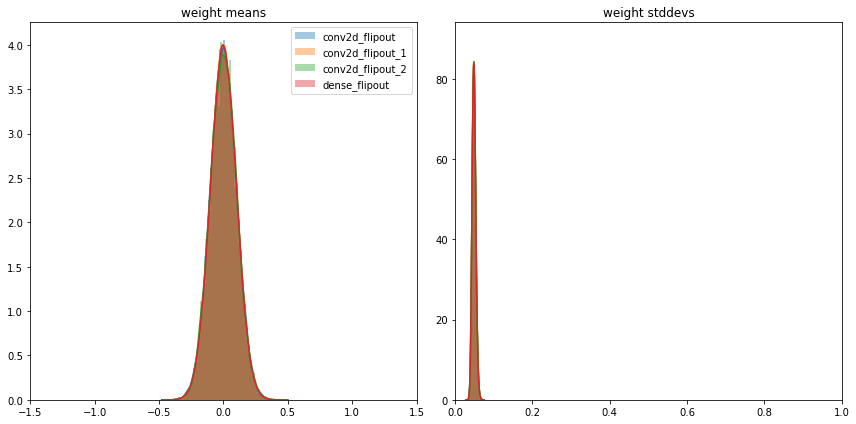

In [11]:
names = [layer.name for layer in model.layers 
        if 'flipout' in layer.name]
# dense_flipout/kernel_posterior_loc:0
qm_vals = [layer.kernel_posterior.mean() 
        for layer in model.layers
        if 'flipout' in layer.name]

qs_vals = [layer.kernel_posterior.stddev() 
        for layer in model.layers
        if 'flipout' in layer.name]

plot_weight_posteriors(names, qm_vals, qs_vals)
print("mean of mean is {}, mean variance is {}".
      format(tf.reduce_mean(qm_vals[0]),
      tf.reduce_mean(qs_vals[0])))

In [12]:
# Loads the weights
model.load_weights('./ckpts/10_num_batches/')

In [13]:
img_name = ['stadtpark', 'lenbach', 'woman', 'red_square']
odd_dir = 'data/odd/' + 'stadtpark' + '.jpg'
blur = ['Canon_Ixus70_0_3419_23.png', 
        'Canon_Ixus70_1_3777_21.png',
        'Canon_Ixus70_2_4143_03.png',
        'Canon_Ixus70_1_3812_02.png',
        'Canon_Ixus70_0_3302_22.png']
blur_dir = '../CamModel/post/blur/Canon_Ixus70/'
# for img in img_name:
images = None
images, labels = parse_image(odd_dir, post_processing=False)
probs, heldout_log_prob = compute_probs(images)

 ... Held-out nats: 0.636


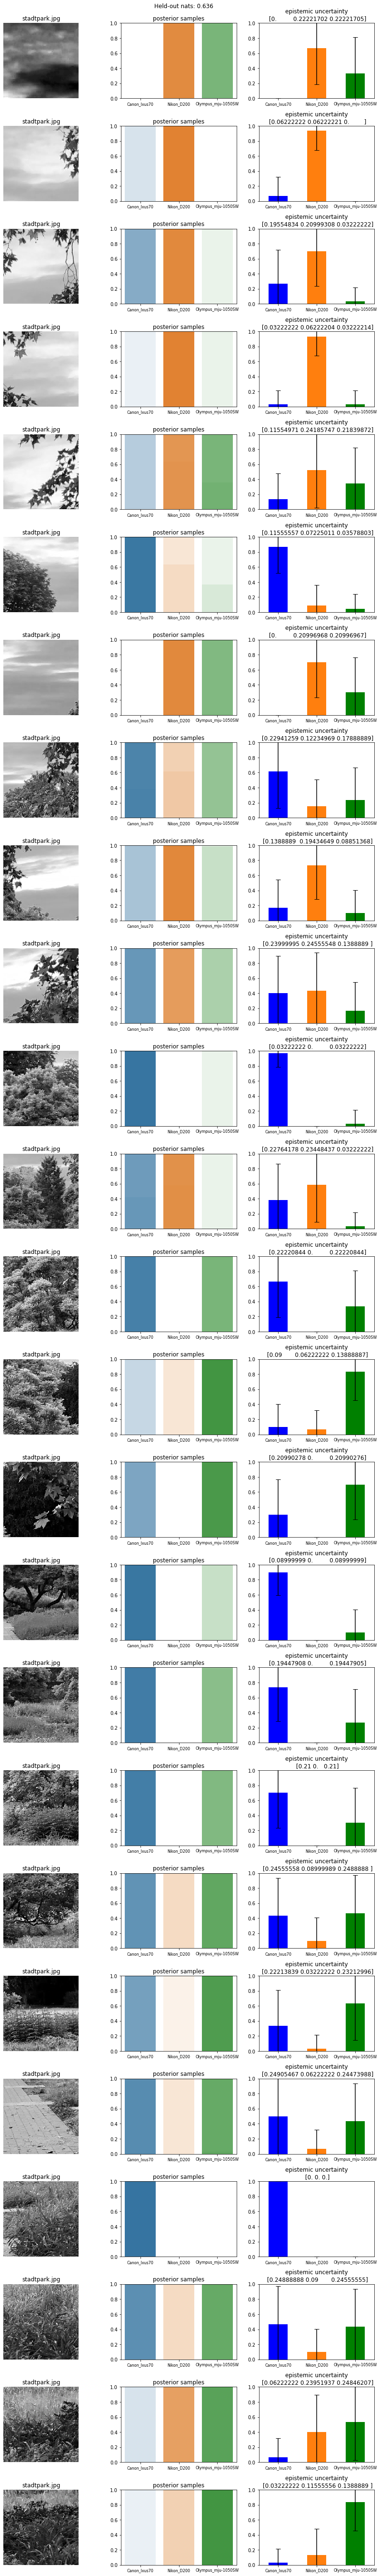

In [14]:
plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, 25)

In [15]:
images, labels = parse_image(odd_dir, post_processing=True)
probs, heldout_log_prob = compute_probs(images)
plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, 25)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
model.summary()

In [ ]:
names = [layer.name for layer in model.layers 
        if 'flipout' in layer.name]
# dense_flipout/kernel_posterior_loc:0
qm_vals = [layer.kernel_posterior.mean() 
        for layer in model.layers
        if 'flipout' in layer.name]

qs_vals = [layer.kernel_posterior.stddev() 
        for layer in model.layers
        if 'flipout' in layer.name]

plot_weight_posteriors(names, qm_vals, qs_vals)
print("mean of mean is {}, mean variance is {}".
      format(tf.reduce_mean(qm_vals[0]),
      tf.reduce_mean(qs_vals[0])))